In [88]:
import ast
import cairosvg
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
from pathlib import Path

from matplotlib.ticker import FormatStrFormatter
from typing import Tuple, List, Dict

In [41]:
def get_model_and_sample_size_and_fold_wise_metrics(metrics_dir: str) -> Dict[str, Dict[str, Dict[str, Dict]]]:
    model_wise_dict: Dict[str, Dict] = dict()
    metrics_files: List[str] = glob.glob(os.path.join(metrics_dir, "**", "*.txt"))
    model_names: List[str] = list({Path(path).parts[1] for path in metrics_files if len(Path(path).parts) > 2})
    model_wise_files: Dict[str, List[str]] = {model_name: [path for path in metrics_files if model_name in path] for model_name in model_names}
    for model_name in model_names:
        sample_size_wise_dict: Dict[str, Dict] = dict()
        sample_sizes: List[str] = list({os.path.basename(path).split("-")[0] for path in model_wise_files[model_name]})
        sample_size_wise_files: Dict[str, List[str]] = {sample_size: [path for path in model_wise_files[model_name] if sample_size in path] for sample_size in sample_sizes}
        for sample_size in sample_sizes:
            fold_wise_dict: Dict[str, Dict] = dict()
            for path in sample_size_wise_files[sample_size]:
                fold = os.path.basename(path).split("-")[1].split(".")[0]
                with open((Path(path)), "r") as file_reader:
                    fold_dict_str: str = file_reader.read()
                    fold_dict: Dict = ast.literal_eval(fold_dict_str)
                    fold_wise_dict[fold] = fold_dict
            sample_size_wise_dict[sample_size] = fold_wise_dict
        model_wise_dict[model_name] = sample_size_wise_dict
    return model_wise_dict

In [53]:
def get_model_wise_performance_metrics(metrics_dir: str, 
                                       model_names: List[str],
                                       sample_size: int = 10_000,
                                       folds: List[int] = [1, 2, 3, 4, 5]) -> Dict[str, List[List[List[float]]]]:
    
    performance_metrics_dict: Dict[str, List[List[List[float]]]] = dict()
    model_wise_dict: Dict[str, Dict] = get_model_and_sample_size_and_fold_wise_metrics(metrics_dir)
    keys: List[str] = list(model_wise_dict[model_names[0]][f'{sample_size//1000}K'][f'K{folds[0]}'].keys())
    for key in keys:
        model_metrics_list: List[List[List[float]]] = list()
        for model_name in model_names:
            precision_list: List[float] = list()
            recall_list: List[float] = list()
            f1_list: List[float] = list()
            for fold in folds:
                precision_list.append(round(model_wise_dict[model_name][f'{sample_size//1000}K'][f'K{fold}'][key]['precision'], 4))
                recall_list.append(round(model_wise_dict[model_name][f'{sample_size//1000}K'][f'K{fold}'][key]['recall'], 4))
                f1_list.append(round(model_wise_dict[model_name][f'{sample_size//1000}K'][f'K{fold}'][key]['f1-score'], 4))
            model_metrics_list.append([precision_list, recall_list, f1_list])
        performance_metrics_dict[key] = model_metrics_list
    return performance_metrics_dict

In [89]:
metrics_data = get_model_wise_performance_metrics(
    metrics_dir='ner_performance_metrics',
    model_names=[
     'bilstm_crf_bpemb_char',
     'gelectra_bpemb_fasttext_context',
     'mt5'
    ]
)

models = ['BiLSTM-CRF', 'GELECTRA', 'mT5']
metrics = ['Prec', 'Rec', 'F1']

In [91]:
plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

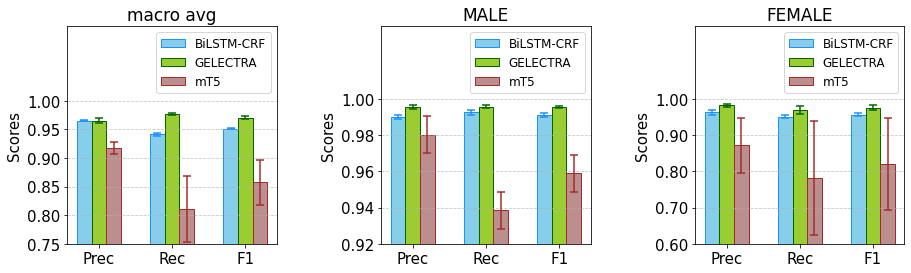

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.50)

# Set the width of each bar and the position of groups
bar_width = 0.040  # Width of the bars
index = np.arange(len(metrics)) * 0.20  # Adjust spacing between metrics



# macro avg
macro_avg_data = np.array(metrics_data['macro avg'])

# Compute the mean and standard deviation for each group and bar
macro_avg_means = np.mean(macro_avg_data, axis=2)
macro_avg_std_devs = np.std(macro_avg_data, axis=2)

# print(f'{macro_avg_means+macro_avg_std_devs}')
# print(f'{macro_avg_means-macro_avg_std_devs}')

# Plot bars for each model with specified colors
axes[0].bar(
    index, 
    macro_avg_means[0], 
    bar_width, 
    label=models[0], 
    color='skyblue', 
    edgecolor='dodgerblue', 
    align='center',
    yerr=macro_avg_std_devs[0],
    error_kw = {
        'ecolor': 'dodgerblue',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[0].bar(
    index + bar_width, 
    macro_avg_means[1],
    bar_width,
    label=models[1],
    color='yellowgreen',
    edgecolor='darkgreen',
    align='center',
    yerr=macro_avg_std_devs[1], 
    error_kw = {
        'ecolor': 'darkgreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[0].bar(
    index + 2 * bar_width,
    macro_avg_means[2],
    bar_width,
    label=models[2],
    color='rosybrown',
    edgecolor='brown',
    align='center',
    yerr=macro_avg_std_devs[2], 
    error_kw = {
        'ecolor': 'brown',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[0].set_title('macro avg', fontsize=17)
axes[0].set_ylim(0.75, 1.13)
axes[0].set_yticks(np.arange(0.75, 1.01, 0.05))
axes[0].legend(loc='upper right', fontsize=12)
axes[0].set_ylabel('Scores', fontsize=15, labelpad=5)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(metrics)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)



# MALE
male_data = np.array(metrics_data['MALE'])

# Compute the mean and standard deviation for each group and bar
male_means = np.mean(male_data, axis=2)
male_std_devs = np.std(male_data, axis=2)

# print(f'{male_means+male_std_devs}')
# print(f'{male_means-male_std_devs}')

# Plot bars for each model with specified colors
axes[1].bar(index, 
    male_means[0], 
    bar_width, 
    label=models[0], 
    color='skyblue', 
    edgecolor='dodgerblue',
    align='center',
    yerr=male_std_devs[0],
    error_kw = {
        'ecolor': 'dodgerblue',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[1].bar(
    index + bar_width, 
    male_means[1],
    bar_width,
    label=models[1],
    color='yellowgreen',
    edgecolor='darkgreen',
    align='center',
    yerr=male_std_devs[1], 
    error_kw = {
        'ecolor': 'darkgreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[1].bar(
    index + 2 * bar_width,
    male_means[2],
    bar_width,
    label=models[2],
    color='rosybrown',
    edgecolor='brown',
    align='center',
    yerr=male_std_devs[2], 
    error_kw = {
        'ecolor': 'brown',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[1].set_title('MALE', fontsize=17)
axes[1].set_ylim(0.92, 1.04)
axes[1].set_yticks(np.arange(0.92, 1.01, 0.02))
axes[1].legend(loc='upper right', fontsize=12)
axes[1].set_ylabel('Scores', fontsize=15, labelpad=5)
axes[1].set_xticks(index + bar_width)
axes[1].set_xticklabels(metrics)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)



# FEMALE
female_data = np.array(metrics_data['FEMALE'])

# Compute the mean and standard deviation for each group and bar
female_means = np.mean(female_data, axis=2)
female_std_devs = np.std(female_data, axis=2)

# print(f'{female_means+female_std_devs}')
# print(f'{female_means-female_std_devs}')

# Plot bars for each model with specified colors
axes[2].bar(
    index, 
    female_means[0], 
    bar_width, 
    label=models[0], 
    color='skyblue', 
    edgecolor='dodgerblue', 
    align='center',
    yerr=female_std_devs[0],
    error_kw = {
        'ecolor': 'dodgerblue',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[2].bar(
    index + bar_width, 
    female_means[1],
    bar_width,
    label=models[1],
    color='yellowgreen',
    edgecolor='darkgreen',
    align='center',
    yerr=female_std_devs[1], 
    error_kw = {
        'ecolor': 'darkgreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[2].bar(
    index + 2 * bar_width,
    female_means[2],
    bar_width,
    label=models[2],
    color='rosybrown',
    edgecolor='brown',
    align='center',
    yerr=female_std_devs[2], 
    error_kw = {
        'ecolor': 'brown',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[2].set_title('FEMALE', fontsize=17)
axes[2].set_ylim(0.60, 1.2)
axes[2].set_yticks(np.arange(0.60, 1.01, 0.10))
axes[2].legend(loc='upper right', fontsize=12)
axes[2].set_ylabel('Scores', fontsize=15, labelpad=5)
axes[2].set_xticks(index + bar_width)
axes[2].set_xticklabels(metrics)
axes[2].tick_params(axis='y', labelsize=15)
axes[2].tick_params(axis='x', labelsize=15)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plot_file_ext = "svg"
plot_name = "entity_prediction_performance_comparison_of_models_macro_avg_male_female"
plot_file_name = f"{plot_name}.{plot_file_ext}"
plot_file_path = os.path.join(plots_dir, plot_file_name)
plt.savefig(plot_file_path, format=plot_file_ext, dpi=1200, bbox_inches='tight')

# Convert to pdf
plot_pdf_name = f"{plot_name}.pdf"
plot_pdf_path = os.path.join(plots_dir, plot_pdf_name)
cairosvg.svg2pdf(url=plot_file_path, write_to=plot_pdf_path)

plt.show()

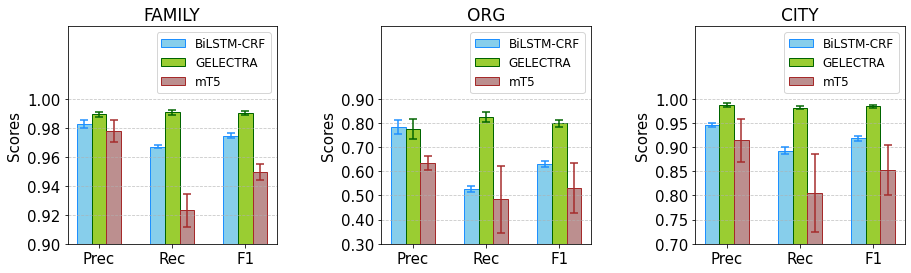

In [112]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.50)

# Set the width of each bar and the position of groups
bar_width = 0.040  # Width of the bars
index = np.arange(len(metrics)) * 0.20  # Adjust spacing between metrics



# FAMILY
family_avg_data = np.array(metrics_data['FAMILY'])

# Compute the mean and standard deviation for each group and bar
family_avg_means = np.mean(family_avg_data, axis=2)
family_avg_std_devs = np.std(family_avg_data, axis=2)

# print(f'{family_avg_means+family_avg_std_devs}')
# print(f'{family_avg_means-family_avg_std_devs}')

# Plot bars for each model with specified colors
axes[0].bar(
    index, 
    family_avg_means[0], 
    bar_width, 
    label=models[0], 
    color='skyblue', 
    edgecolor='dodgerblue', 
    align='center',
    yerr=family_avg_std_devs[0],
    error_kw = {
        'ecolor': 'dodgerblue',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[0].bar(
    index + bar_width, 
    family_avg_means[1],
    bar_width,
    label=models[1],
    color='yellowgreen',
    edgecolor='darkgreen',
    align='center',
    yerr=family_avg_std_devs[1], 
    error_kw = {
        'ecolor': 'darkgreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[0].bar(
    index + 2 * bar_width,
    family_avg_means[2],
    bar_width,
    label=models[2],
    color='rosybrown',
    edgecolor='brown',
    align='center',
    yerr=family_avg_std_devs[2], 
    error_kw = {
        'ecolor': 'brown',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[0].set_title('FAMILY', fontsize=17)
axes[0].set_ylim(0.90, 1.05)
axes[0].set_yticks(np.arange(0.90, 1.01, 0.02))
axes[0].legend(loc='upper right', fontsize=12)
axes[0].set_ylabel('Scores', fontsize=15, labelpad=5)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(metrics)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)



# ORG
org_data = np.array(metrics_data['ORG'])

# Compute the mean and standard deviation for each group and bar
org_means = np.mean(org_data, axis=2)
org_std_devs = np.std(org_data, axis=2)

# print(f'{org_means+org_std_devs}')
# print(f'{org_means-org_std_devs}')

# Plot bars for each model with specified colors
axes[1].bar(index, 
    org_means[0], 
    bar_width, 
    label=models[0], 
    color='skyblue', 
    edgecolor='dodgerblue',
    align='center',
    yerr=org_std_devs[0],
    error_kw = {
        'ecolor': 'dodgerblue',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[1].bar(
    index + bar_width, 
    org_means[1],
    bar_width,
    label=models[1],
    color='yellowgreen',
    edgecolor='darkgreen',
    align='center',
    yerr=org_std_devs[1], 
    error_kw = {
        'ecolor': 'darkgreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[1].bar(
    index + 2 * bar_width,
    org_means[2],
    bar_width,
    label=models[2],
    color='rosybrown',
    edgecolor='brown',
    align='center',
    yerr=org_std_devs[2], 
    error_kw = {
        'ecolor': 'brown',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[1].set_title('ORG', fontsize=17)
axes[1].set_ylim(0.30, 1.20)
axes[1].set_yticks(np.arange(0.30, 0.91, 0.10))
axes[1].legend(loc='upper right', fontsize=12)
axes[1].set_ylabel('Scores', fontsize=15, labelpad=5)
axes[1].set_xticks(index + bar_width)
axes[1].set_xticklabels(metrics)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))



# CITY
city_data = np.array(metrics_data['CITY'])

# Compute the mean and standard deviation for each group and bar
city_means = np.mean(city_data, axis=2)
city_std_devs = np.std(city_data, axis=2)

# print(f'{city_means+city_std_devs}')
# print(f'{city_means-city_std_devs}')

# Plot bars for each model with specified colors
axes[2].bar(
    index, 
    city_means[0], 
    bar_width, 
    label=models[0], 
    color='skyblue', 
    edgecolor='dodgerblue', 
    align='center',
    yerr=city_std_devs[0],
    error_kw = {
        'ecolor': 'dodgerblue',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[2].bar(
    index + bar_width, 
    city_means[1],
    bar_width,
    label=models[1],
    color='yellowgreen',
    edgecolor='darkgreen',
    align='center',
    yerr=city_std_devs[1], 
    error_kw = {
        'ecolor': 'darkgreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[2].bar(
    index + 2 * bar_width,
    city_means[2],
    bar_width,
    label=models[2],
    color='rosybrown',
    edgecolor='brown',
    align='center',
    yerr=city_std_devs[2], 
    error_kw = {
        'ecolor': 'brown',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[2].set_title('CITY', fontsize=17)
axes[2].set_ylim(0.70, 1.15)
axes[2].set_yticks(np.arange(0.70, 1.01, 0.05))
axes[2].legend(loc='upper right', fontsize=12)
axes[2].set_ylabel('Scores', fontsize=15, labelpad=5)
axes[2].set_xticks(index + bar_width)
axes[2].set_xticklabels(metrics)
axes[2].tick_params(axis='y', labelsize=15)
axes[2].tick_params(axis='x', labelsize=15)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plot_file_ext = "svg"
plot_name = "entity_prediction_performance_comparison_of_models_family_org_city"
plot_file_name = f"{plot_name}.{plot_file_ext}"
plot_file_path = os.path.join(plots_dir, plot_file_name)
plt.savefig(plot_file_path, format=plot_file_ext, dpi=1200, bbox_inches='tight')

# Convert to pdf
plot_pdf_name = f"{plot_name}.pdf"
plot_pdf_path = os.path.join(plots_dir, plot_pdf_name)
cairosvg.svg2pdf(url=plot_file_path, write_to=plot_pdf_path)

plt.show()

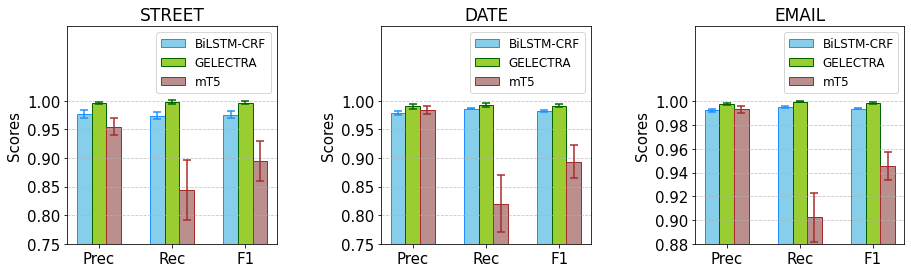

In [126]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.50)

# Set the width of each bar and the position of groups
bar_width = 0.040  # Width of the bars
index = np.arange(len(metrics)) * 0.20  # Adjust spacing between metrics



# STREET
street_avg_data = np.array(metrics_data['STREET'])

# Compute the mean and standard deviation for each group and bar
street_avg_means = np.mean(street_avg_data, axis=2)
street_avg_std_devs = np.std(street_avg_data, axis=2)

# print(f'{street_avg_means+street_avg_std_devs}')
# print(f'{street_avg_means-street_avg_std_devs}')

# Plot bars for each model with specified colors
axes[0].bar(
    index, 
    street_avg_means[0], 
    bar_width, 
    label=models[0], 
    color='skyblue', 
    edgecolor='dodgerblue', 
    align='center',
    yerr=street_avg_std_devs[0],
    error_kw = {
        'ecolor': 'dodgerblue',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[0].bar(
    index + bar_width, 
    street_avg_means[1],
    bar_width,
    label=models[1],
    color='yellowgreen',
    edgecolor='darkgreen',
    align='center',
    yerr=street_avg_std_devs[1], 
    error_kw = {
        'ecolor': 'darkgreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[0].bar(
    index + 2 * bar_width,
    street_avg_means[2],
    bar_width,
    label=models[2],
    color='rosybrown',
    edgecolor='brown',
    align='center',
    yerr=street_avg_std_devs[2], 
    error_kw = {
        'ecolor': 'brown',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[0].set_title('STREET', fontsize=17)
axes[0].set_ylim(0.75, 1.13)
axes[0].set_yticks(np.arange(0.75, 1.01, 0.05))
axes[0].legend(loc='upper right', fontsize=12)
axes[0].set_ylabel('Scores', fontsize=15, labelpad=5)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(metrics)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)



# DATE
date_data = np.array(metrics_data['DATE'])

# Compute the mean and standard deviation for each group and bar
date_means = np.mean(date_data, axis=2)
date_std_devs = np.std(date_data, axis=2)

# print(f'{date_means+date_std_devs}')
# print(f'{date_means-date_std_devs}')

# Plot bars for each model with specified colors
axes[1].bar(index, 
    date_means[0], 
    bar_width, 
    label=models[0], 
    color='skyblue', 
    edgecolor='dodgerblue',
    align='center',
    yerr=date_std_devs[0],
    error_kw = {
        'ecolor': 'dodgerblue',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[1].bar(
    index + bar_width, 
    date_means[1],
    bar_width,
    label=models[1],
    color='yellowgreen',
    edgecolor='darkgreen',
    align='center',
    yerr=date_std_devs[1], 
    error_kw = {
        'ecolor': 'darkgreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[1].bar(
    index + 2 * bar_width,
    date_means[2],
    bar_width,
    label=models[2],
    color='rosybrown',
    edgecolor='brown',
    align='center',
    yerr=date_std_devs[2], 
    error_kw = {
        'ecolor': 'brown',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[1].set_title('DATE', fontsize=17)
axes[1].set_ylim(0.75, 1.13)
axes[1].set_yticks(np.arange(0.75, 1.01, 0.05))
axes[1].legend(loc='upper right', fontsize=12)
axes[1].set_ylabel('Scores', fontsize=15, labelpad=5)
axes[1].set_xticks(index + bar_width)
axes[1].set_xticklabels(metrics)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))



# EMAIL
email_data = np.array(metrics_data['EMAIL'])

# Compute the mean and standard deviation for each group and bar
email_means = np.mean(email_data, axis=2)
email_std_devs = np.std(email_data, axis=2)

# print(f'{email_means+email_std_devs}')
# print(f'{email_means-email_std_devs}')

# Plot bars for each model with specified colors
axes[2].bar(
    index, 
    email_means[0], 
    bar_width, 
    label=models[0], 
    color='skyblue', 
    edgecolor='dodgerblue', 
    align='center',
    yerr=email_std_devs[0],
    error_kw = {
        'ecolor': 'dodgerblue',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[2].bar(
    index + bar_width, 
    email_means[1],
    bar_width,
    label=models[1],
    color='yellowgreen',
    edgecolor='darkgreen',
    align='center',
    yerr=email_std_devs[1], 
    error_kw = {
        'ecolor': 'darkgreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[2].bar(
    index + 2 * bar_width,
    email_means[2],
    bar_width,
    label=models[2],
    color='rosybrown',
    edgecolor='brown',
    align='center',
    yerr=email_std_devs[2], 
    error_kw = {
        'ecolor': 'brown',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[2].set_title('EMAIL', fontsize=17)
axes[2].set_ylim(0.88, 1.063)
axes[2].set_yticks(np.arange(0.88, 1.01, 0.02))
axes[2].legend(loc='upper right', fontsize=12)
axes[2].set_ylabel('Scores', fontsize=15, labelpad=5)
axes[2].set_xticks(index + bar_width)
axes[2].set_xticklabels(metrics)
axes[2].tick_params(axis='y', labelsize=15)
axes[2].tick_params(axis='x', labelsize=15)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plot_file_ext = "svg"
plot_name = "entity_prediction_performance_comparison_of_models_street_date_email"
plot_file_name = f"{plot_name}.{plot_file_ext}"
plot_file_path = os.path.join(plots_dir, plot_file_name)
plt.savefig(plot_file_path, format=plot_file_ext, dpi=1200, bbox_inches='tight')

# Convert to pdf
plot_pdf_name = f"{plot_name}.pdf"
plot_pdf_path = os.path.join(plots_dir, plot_pdf_name)
cairosvg.svg2pdf(url=plot_file_path, write_to=plot_pdf_path)

plt.show()

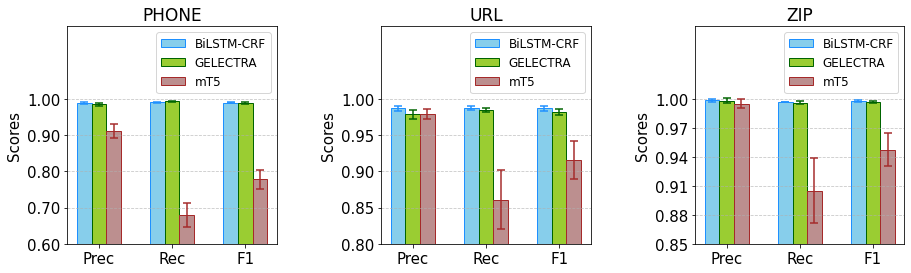

In [142]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.50)

# Set the width of each bar and the position of groups
bar_width = 0.040  # Width of the bars
index = np.arange(len(metrics)) * 0.20  # Adjust spacing between metrics



# PHONE
phone_avg_data = np.array(metrics_data['PHONE'])

# Compute the mean and standard deviation for each group and bar
phone_avg_means = np.mean(phone_avg_data, axis=2)
phone_avg_std_devs = np.std(phone_avg_data, axis=2)

# print(f'{phone_avg_means+phone_avg_std_devs}')
# print(f'{phone_avg_means-phone_avg_std_devs}')

# Plot bars for each model with specified colors
axes[0].bar(
    index, 
    phone_avg_means[0], 
    bar_width, 
    label=models[0], 
    color='skyblue', 
    edgecolor='dodgerblue', 
    align='center',
    yerr=phone_avg_std_devs[0],
    error_kw = {
        'ecolor': 'dodgerblue',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[0].bar(
    index + bar_width, 
    phone_avg_means[1],
    bar_width,
    label=models[1],
    color='yellowgreen',
    edgecolor='darkgreen',
    align='center',
    yerr=phone_avg_std_devs[1], 
    error_kw = {
        'ecolor': 'darkgreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[0].bar(
    index + 2 * bar_width,
    phone_avg_means[2],
    bar_width,
    label=models[2],
    color='rosybrown',
    edgecolor='brown',
    align='center',
    yerr=phone_avg_std_devs[2], 
    error_kw = {
        'ecolor': 'brown',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[0].set_title('PHONE', fontsize=17)
axes[0].set_ylim(0.60, 1.20)
axes[0].set_yticks(np.arange(0.60, 1.01, 0.1))
axes[0].legend(loc='upper right', fontsize=12)
axes[0].set_ylabel('Scores', fontsize=15, labelpad=5)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(metrics)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


# URL
url_data = np.array(metrics_data['URL'])

# Compute the mean and standard deviation for each group and bar
url_means = np.mean(url_data, axis=2)
url_std_devs = np.std(url_data, axis=2)

# print(f'{url_means+url_std_devs}')
# print(f'{url_means-url_std_devs}')

# Plot bars for each model with specified colors
axes[1].bar(index, 
    url_means[0], 
    bar_width, 
    label=models[0], 
    color='skyblue', 
    edgecolor='dodgerblue',
    align='center',
    yerr=url_std_devs[0],
    error_kw = {
        'ecolor': 'dodgerblue',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[1].bar(
    index + bar_width, 
    url_means[1],
    bar_width,
    label=models[1],
    color='yellowgreen',
    edgecolor='darkgreen',
    align='center',
    yerr=url_std_devs[1], 
    error_kw = {
        'ecolor': 'darkgreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[1].bar(
    index + 2 * bar_width,
    url_means[2],
    bar_width,
    label=models[2],
    color='rosybrown',
    edgecolor='brown',
    align='center',
    yerr=url_std_devs[2], 
    error_kw = {
        'ecolor': 'brown',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[1].set_title('URL', fontsize=17)
axes[1].set_ylim(0.80, 1.10)
axes[1].set_yticks(np.arange(0.80, 1.01, 0.05))
axes[1].legend(loc='upper right', fontsize=12)
axes[1].set_ylabel('Scores', fontsize=15, labelpad=5)
axes[1].set_xticks(index + bar_width)
axes[1].set_xticklabels(metrics)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))



# ZIP
zip_data = np.array(metrics_data['ZIP'])

# Compute the mean and standard deviation for each group and bar
zip_means = np.mean(zip_data, axis=2)
zip_std_devs = np.std(zip_data, axis=2)

# print(f'{zip_means+zip_std_devs}')
# print(f'{zip_means-zip_std_devs}')

# Plot bars for each model with specified colors
axes[2].bar(
    index, 
    zip_means[0], 
    bar_width, 
    label=models[0], 
    color='skyblue', 
    edgecolor='dodgerblue', 
    align='center',
    yerr=zip_std_devs[0],
    error_kw = {
        'ecolor': 'dodgerblue',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[2].bar(
    index + bar_width, 
    zip_means[1],
    bar_width,
    label=models[1],
    color='yellowgreen',
    edgecolor='darkgreen',
    align='center',
    yerr=zip_std_devs[1], 
    error_kw = {
        'ecolor': 'darkgreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[2].bar(
    index + 2 * bar_width,
    zip_means[2],
    bar_width,
    label=models[2],
    color='rosybrown',
    edgecolor='brown',
    align='center',
    yerr=zip_std_devs[2], 
    error_kw = {
        'ecolor': 'brown',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[2].set_title('ZIP', fontsize=17)
axes[2].set_ylim(0.85, 1.075)
axes[2].set_yticks(np.arange(0.85, 1.01, 0.03))
axes[2].legend(loc='upper right', fontsize=12)
axes[2].set_ylabel('Scores', fontsize=15, labelpad=5)
axes[2].set_xticks(index + bar_width)
axes[2].set_xticklabels(metrics)
axes[2].tick_params(axis='y', labelsize=15)
axes[2].tick_params(axis='x', labelsize=15)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plot_file_ext = "svg"
plot_name = "entity_prediction_performance_comparison_of_models_phone_url_zip"
plot_file_name = f"{plot_name}.{plot_file_ext}"
plot_file_path = os.path.join(plots_dir, plot_file_name)
plt.savefig(plot_file_path, format=plot_file_ext, dpi=1200, bbox_inches='tight')

# Convert to pdf
plot_pdf_name = f"{plot_name}.pdf"
plot_pdf_path = os.path.join(plots_dir, plot_pdf_name)
cairosvg.svg2pdf(url=plot_file_path, write_to=plot_pdf_path)

plt.show()

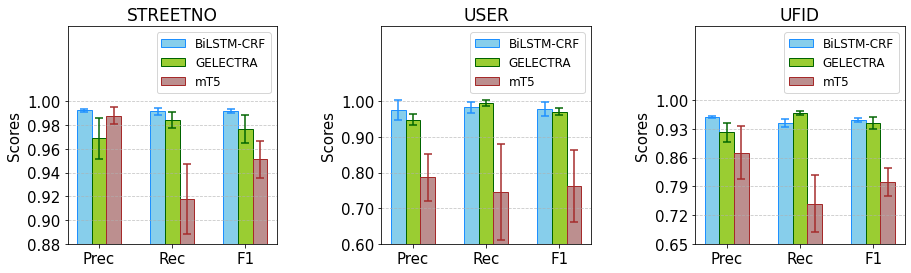

In [159]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.50)

# Set the width of each bar and the position of groups
bar_width = 0.040  # Width of the bars
index = np.arange(len(metrics)) * 0.20  # Adjust spacing between metrics



# STREETNO
streetno_avg_data = np.array(metrics_data['STREETNO'])

# Compute the mean and standard deviation for each group and bar
streetno_avg_means = np.mean(streetno_avg_data, axis=2)
streetno_avg_std_devs = np.std(streetno_avg_data, axis=2)

# print(f'{streetno_avg_means+streetno_avg_std_devs}')
# print(f'{streetno_avg_means-streetno_avg_std_devs}')

# Plot bars for each model with specified colors
axes[0].bar(
    index, 
    streetno_avg_means[0], 
    bar_width, 
    label=models[0], 
    color='skyblue', 
    edgecolor='dodgerblue', 
    align='center',
    yerr=streetno_avg_std_devs[0],
    error_kw = {
        'ecolor': 'dodgerblue',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[0].bar(
    index + bar_width, 
    streetno_avg_means[1],
    bar_width,
    label=models[1],
    color='yellowgreen',
    edgecolor='darkgreen',
    align='center',
    yerr=streetno_avg_std_devs[1], 
    error_kw = {
        'ecolor': 'darkgreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[0].bar(
    index + 2 * bar_width,
    streetno_avg_means[2],
    bar_width,
    label=models[2],
    color='rosybrown',
    edgecolor='brown',
    align='center',
    yerr=streetno_avg_std_devs[2], 
    error_kw = {
        'ecolor': 'brown',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[0].set_title('STREETNO', fontsize=17)
axes[0].set_ylim(0.88, 1.063)
axes[0].set_yticks(np.arange(0.88, 1.01, 0.02))
axes[0].legend(loc='upper right', fontsize=12)
axes[0].set_ylabel('Scores', fontsize=15, labelpad=5)
axes[0].set_xticks(index + bar_width)
axes[0].set_xticklabels(metrics)
axes[0].tick_params(axis='y', labelsize=15)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))


# USER
user_data = np.array(metrics_data['USER'])

# Compute the mean and standard deviation for each group and bar
user_means = np.mean(user_data, axis=2)
user_std_devs = np.std(user_data, axis=2)

# print(f'{user_means+user_std_devs}')
# print(f'{user_means-user_std_devs}')

# Plot bars for each model with specified colors
axes[1].bar(index, 
    user_means[0], 
    bar_width, 
    label=models[0], 
    color='skyblue', 
    edgecolor='dodgerblue',
    align='center',
    yerr=user_std_devs[0],
    error_kw = {
        'ecolor': 'dodgerblue',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[1].bar(
    index + bar_width, 
    user_means[1],
    bar_width,
    label=models[1],
    color='yellowgreen',
    edgecolor='darkgreen',
    align='center',
    yerr=user_std_devs[1], 
    error_kw = {
        'ecolor': 'darkgreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[1].bar(
    index + 2 * bar_width,
    user_means[2],
    bar_width,
    label=models[2],
    color='rosybrown',
    edgecolor='brown',
    align='center',
    yerr=user_std_devs[2], 
    error_kw = {
        'ecolor': 'brown',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[1].set_title('USER', fontsize=17)
axes[1].set_ylim(0.60, 1.21)
axes[1].set_yticks(np.arange(0.60, 1.01, 0.10))
axes[1].legend(loc='upper right', fontsize=12)
axes[1].set_ylabel('Scores', fontsize=15, labelpad=5)
axes[1].set_xticks(index + bar_width)
axes[1].set_xticklabels(metrics)
axes[1].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))



# UFID
ufid_data = np.array(metrics_data['UFID'])

# Compute the mean and standard deviation for each group and bar
ufid_means = np.mean(ufid_data, axis=2)
ufid_std_devs = np.std(ufid_data, axis=2)

# print(f'{ufid_means+ufid_std_devs}')
# print(f'{ufid_means-ufid_std_devs}')

# Plot bars for each model with specified colors
axes[2].bar(
    index, 
    ufid_means[0], 
    bar_width, 
    label=models[0], 
    color='skyblue', 
    edgecolor='dodgerblue', 
    align='center',
    yerr=ufid_std_devs[0],
    error_kw = {
        'ecolor': 'dodgerblue',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[2].bar(
    index + bar_width, 
    ufid_means[1],
    bar_width,
    label=models[1],
    color='yellowgreen',
    edgecolor='darkgreen',
    align='center',
    yerr=ufid_std_devs[1], 
    error_kw = {
        'ecolor': 'darkgreen',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[2].bar(
    index + 2 * bar_width,
    ufid_means[2],
    bar_width,
    label=models[2],
    color='rosybrown',
    edgecolor='brown',
    align='center',
    yerr=ufid_std_devs[2], 
    error_kw = {
        'ecolor': 'brown',
        'capsize': 4,
        'elinewidth': 1.5,
        'capthick': 1.5
    }
)
axes[2].set_title('UFID', fontsize=17)
axes[2].set_ylim(0.65, 1.18)
axes[2].set_yticks(np.arange(0.65, 1.01, 0.07))
axes[2].legend(loc='upper right', fontsize=12)
axes[2].set_ylabel('Scores', fontsize=15, labelpad=5)
axes[2].set_xticks(index + bar_width)
axes[2].set_xticklabels(metrics)
axes[2].tick_params(axis='y', labelsize=15)
axes[2].tick_params(axis='x', labelsize=15)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plot_file_ext = "svg"
plot_name = "entity_prediction_performance_comparison_of_models_streetno_user_ufid"
plot_file_name = f"{plot_name}.{plot_file_ext}"
plot_file_path = os.path.join(plots_dir, plot_file_name)
plt.savefig(plot_file_path, format=plot_file_ext, dpi=1200, bbox_inches='tight')

# Convert to pdf
plot_pdf_name = f"{plot_name}.pdf"
plot_pdf_path = os.path.join(plots_dir, plot_pdf_name)
cairosvg.svg2pdf(url=plot_file_path, write_to=plot_pdf_path)

plt.show()